In [3]:
'''
IMPORTING DATASETS AND LIBRARIES
- importing all relevant libraries
- loading dataset
- replacing dropout/enrolled/graduate with numerical values
- splitting into three columns for binary data type
'''

import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy 
import pandas as pd
import warnings

# preventing future version warnings
warnings.filterwarnings('ignore') 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

# load the data into a pandas dataframe
dataset = pd.read_csv('dataset.csv', index_col=0)

# re-formatting Target column to be integers 0-2
dataset.replace(inplace = True,to_replace='Dropout',value=0)
dataset.replace(inplace = True,to_replace='Enrolled',value=1)
dataset.replace(inplace = True,to_replace='Graduate',value=2)

# splitting Target into three separate columns for dropouts, enrolled and graduated
dataset = pd.get_dummies(dataset, columns=['Target'])

# looking at data
dataset.info(verbose=True)
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4424 entries, 1 to 1
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Application mode                                4424 non-null   int64  
 1   Application order                               4424 non-null   int64  
 2   Course                                          4424 non-null   int64  
 3   Daytime/evening attendance                      4424 non-null   int64  
 4   Previous qualification                          4424 non-null   int64  
 5   Nationality                                     4424 non-null   int64  
 6   Mothers qualification                           4424 non-null   int64  
 7   Fathers qualification                           4424 non-null   int64  
 8   Mothers occupation                              4424 non-null   int64  
 9   Fathers occupation                          

,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mothers qualification,Fathers qualification,Mothers occupation,Fathers occupation,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_0,Target_1,Target_2
Marital status,,,,,,,,,,,,,,,,,,,,,
1,8,5,2,1,1,1,13,10,6,10,...,0,0,0.000000,0,10.8,1.4,1.74,1,0,0
1,6,1,11,1,1,1,1,3,4,4,...,6,6,13.666667,0,13.9,-0.3,0.79,0,0,1
1,1,5,5,1,1,1,22,27,10,10,...,0,0,0.000000,0,10.8,1.4,1.74,1,0,0
1,8,2,15,1,1,1,23,27,6,4,...,10,5,12.400000,0,9.4,-0.8,-3.12,0,0,1
2,12,1,3,0,1,1,22,28,10,10,...,6,6,13.000000,0,13.9,-0.3,0.79,0,0,1


In [4]:
'''
MAKING DATASETS
- 60/20/20 training/validation/testing split
- balancing dataset
- splitting into X(relevant ) and y(target variable)
* note that random_state=42 is picked so it remembers the last state for ease-of-programming
'''

# 60% of data into a training set
dataset_train, dataset_splitdata = train_test_split(dataset, test_size = 0.4, random_state = 42)

# split remainder in half for validation and testing
dataset_val, dataset_test = train_test_split(dataset_splitdata, test_size = 0.5, random_state = 42)

# balancing dataset
total=len(dataset_train)
nb_dropout=dataset_train['Target_0'].sum()

dataset_dropout=dataset_train.loc[dataset_train['Target_0']==1]
dataset_dontdropout=dataset_train.loc[dataset_train['Target_0']==0].sample(nb_dropout)

resampled_dataset_train=pd.concat((dataset_dropout,dataset_dontdropout))

# splitting dataset into X and y (attribute removal, only socioeconomic factors for X) for training, validation and testing
X_train=resampled_dataset_train[['Fathers qualification', 'Mothers qualification', 'Mothers occupation', 'Fathers occupation','Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder']]
y_train=resampled_dataset_train['Target_0'].values.reshape(-1, 1)

X_val=dataset_val[['Fathers qualification', 'Mothers qualification', 'Mothers occupation', 'Fathers occupation','Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder']]
y_val=dataset_val['Target_0'].values.reshape(-1, 1)

X_test=dataset_test[['Fathers qualification', 'Mothers qualification', 'Mothers occupation', 'Fathers occupation','Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder']]
y_test=dataset_test['Target_0'].values.reshape(-1, 1)

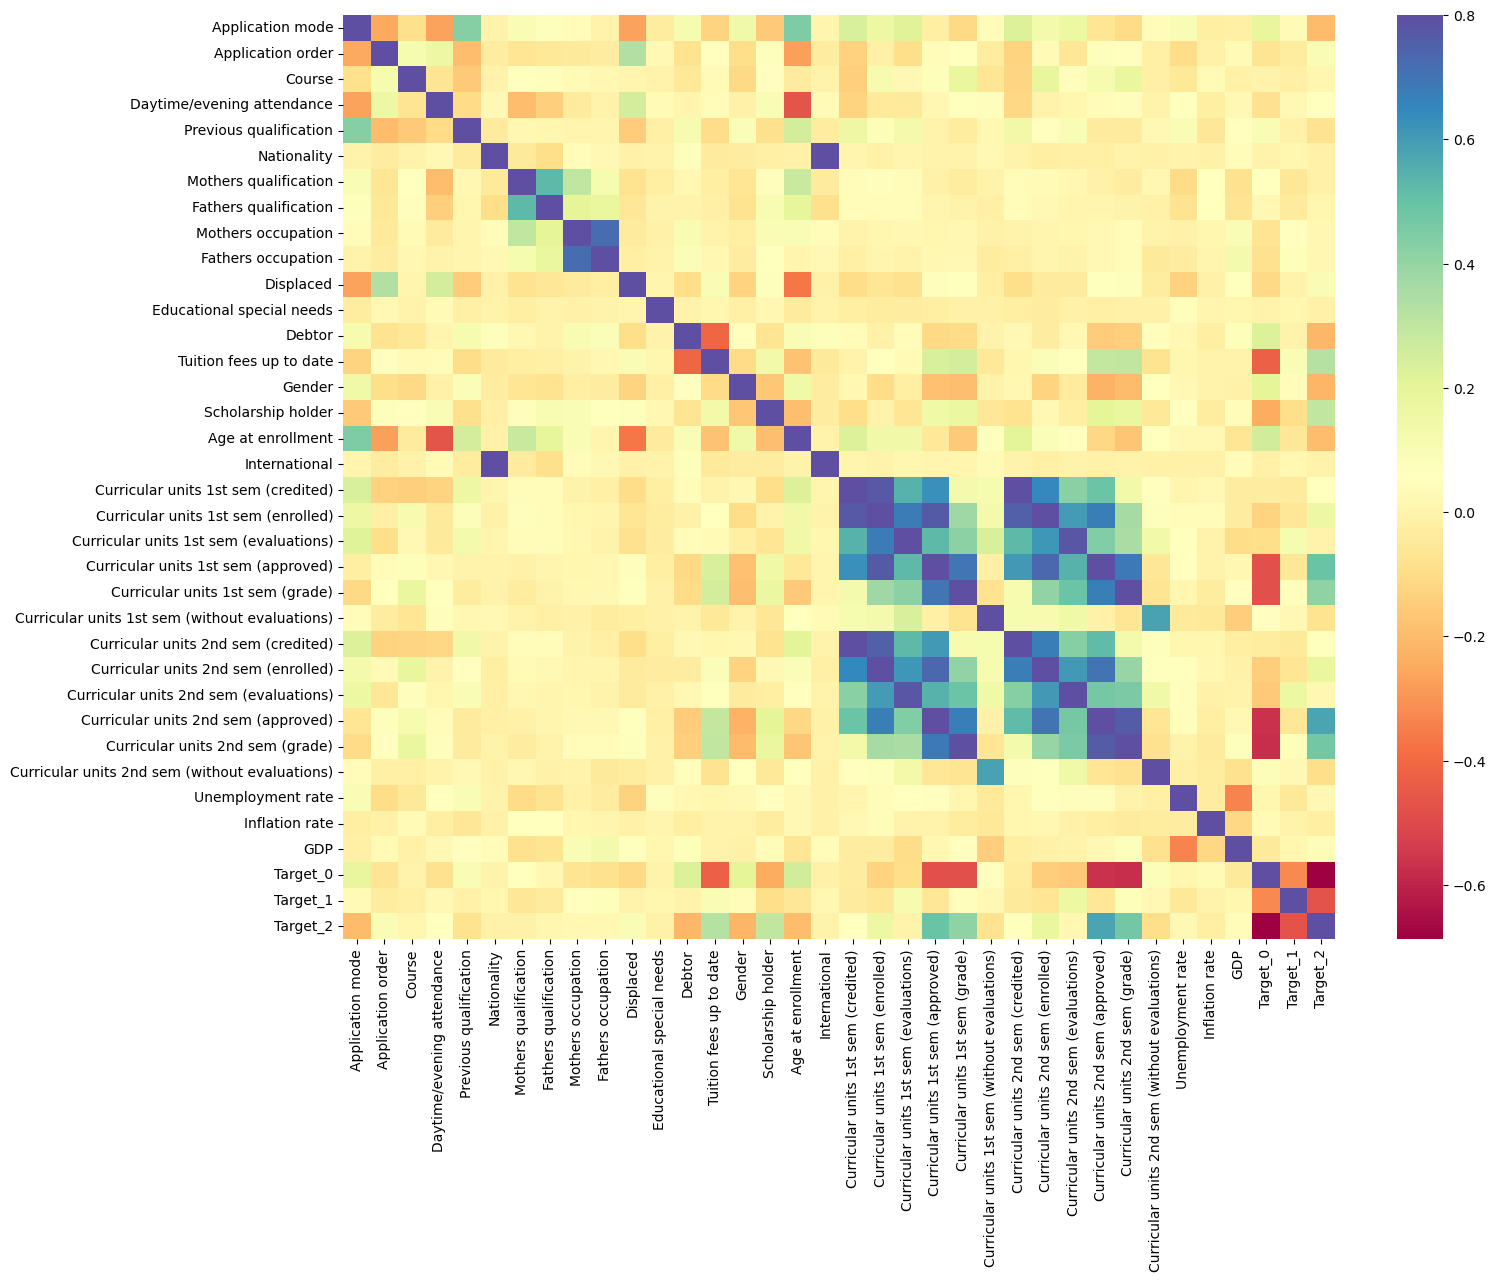

In [3]:
corrmat = dataset.corr()
heatmap = plt.figure(figsize = (16, 12))
sns.heatmap(corrmat, vmax = 0.8, cmap = "Spectral")
plt.show()
corrT = dataset.corr(method = "pearson").round(4)

In [9]:
'''
FORWARD SELECTION ALGORITHM 
- set threshold to 0.05 for accuracy improvement. Smaller values indicate 
smaller incremental improvements required to continue adding features, 
while larger values make it more challenging for a feature to be selected.
- new feature function which deciphers if feature function is within threshold value
- svm forward selection models created 
* note that probability must be set to true for svm.svc to enable probability
estimates, since it internally uses 5-fold cross-validation, and predict_proba
may be inconsistent with predict
- forward_selection function with primary algorithm
- outputs training,validation and test data: confusion matrix, accuracy, precision and recall
'''
# setting threshold value
threshold = 0.05

# new feature function
def new_feature(X_train, y_train, X_val, y_val, current_features, features_to_test):
    
    # Set the next feature to be added to the model to be None
    next_feature = None
    
    # Convert current_features to list
    current_features = list(current_features)
    
    # If there are no current features, accuracy is 0
    if len(current_features) == 0:
        best_accuracy = 0
        
    # svm model created and fit with current features on training data       
    elif len(current_features) == 1:
        svm = SVC(probability=True)
        
        # reshaping model fit to nested list         
        forward_selection_model = svm.fit(X_train[current_features].values.reshape(-1, 1), y_train)
        
        # test model on validation data
        val_prediction = forward_selection_model.predict(X_val[current_features].values.reshape(-1, 1))
        best_accuracy = accuracy_score(y_val, val_prediction)
        
    else:
        # model fit 
        svm = SVC(probability=True)
        forward_selection_model = svm.fit(X_train[current_features], y_train)
        # test model on validation data
        val_prediction = forward_selection_model.predict(X_val[current_features]) 
        best_accuracy = accuracy_score(y_val, val_prediction)
    
    # forming predictions based on new features to identify next feature within threshold
    for feature in features_to_test:
        svm = SVC(probability=True)
        forward_selection_model = svm.fit(X_train[current_features + [feature]],y_train)
        y_prediction = forward_selection_model.predict(X_val[current_features +[feature]])
        accuracy = accuracy_score(y_val, y_prediction)
    
    # if threshold is surpassed than the feature is added !    
    if accuracy - best_accuracy >= threshold: 
        best_accuracy = accuracy
        next_feature = feature
        
    # if new feature = feature, then a new feature is added to the model
    if next_feature != None:
        new_feature_list = current_features + [next_feature]
    else:
        new_feature_list = current_features
    
    # returning new features and best accuracy for use in other function
    return new_feature_list, best_accuracy

def forward_selection(X_train, y_train, X_val, y_val, max_num_features):
    
    # compiling list of possible features from training dataset
    available_features = list(X_train.columns)
    
    # resetting variables
    model_features = [] 
    model_accuracy = 0
    # primary forward selection algorithm
    for i in range(0, max_num_features):
        # calling new_feature function        
        model_features, best_accuracy = new_feature(X_train, y_train, X_val,y_val, model_features, available_features)
        if best_accuracy == model_accuracy:
            break 
        else:
            # continuing algorithm until dataset has all been checked            
            for feature in available_features: 
                if feature in model_features:
                    available_features.remove(feature)
    return model_features, best_accuracy

# through testing, I found that this maxmimum number of features was sufficient while varying threshold
num_features = 2
model_features, best_accuracy = forward_selection(X_train, y_train, X_val,y_val, num_features)

# printing selected features and optimum accuracy
print("Selected features:", model_features)
print("Best accuracy:", best_accuracy)

# overall model being tested
final_training = X_train[model_features]
final_val = X_val[model_features]
final_test = X_test[model_features]

# svm being run
svm = SVC(probability=True)
svm = svm.fit(final_training, y_train)

# Model prediction with train, validation and test data
train_prediction = svm.predict(final_training) 
val_prediction = svm.predict(final_val) 
test_prediction = svm.predict(final_test)

# printing training data
print("\nTraining data:")
# confusion matrix
conf_matrix = confusion_matrix(y_train, train_prediction, labels = [1, 0]) 
print("Confusion Matrix:")
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in conf_matrix]))
# other metrics
print("Accuracy:", accuracy_score(y_train, train_prediction)) 
print("Precision:", precision_score(y_train, train_prediction)) 
print("Recall:", recall_score(y_train, train_prediction))

# printing validation data
print("\nValidation data:")
# confusion matrix
conf_matrix = confusion_matrix(y_val, val_prediction, labels = [1, 0])
print("Confusion Matrix:")
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in conf_matrix]))
# other metrics
print("Accuracy:", accuracy_score(y_val, val_prediction)) 
print("Precision:", precision_score(y_val, val_prediction)) 
print("Recall:", recall_score(y_val, val_prediction))

# printing test data
print("\nTest data:")
# confusion matrix
conf_matrix = confusion_matrix(y_test, test_prediction, labels = [1, 0]) 
print("Confusion Matrix:")
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in conf_matrix]))
# other metrics
print("Accuracy:", accuracy_score(y_test, test_prediction)) 
print("Precision:", precision_score(y_test, test_prediction)) 
print("Recall:", recall_score(y_test, test_prediction))

Selected features: ['Scholarship holder', 'Tuition fees up to date']
Best accuracy: 0.7694915254237288

Training data:
Confusion Matrix:
262	571
23	810
Accuracy: 0.6434573829531812
Precision: 0.9192982456140351
Recall: 0.31452581032412963

Validation data:
Confusion Matrix:
101	196
8	580
Accuracy: 0.7694915254237288
Precision: 0.926605504587156
Recall: 0.3400673400673401

Test data:
Confusion Matrix:
94	197
15	579
Accuracy: 0.7604519774011299
Precision: 0.8623853211009175
Recall: 0.3230240549828179


In [ ]:
'''
SVM PLOTS
- initially using default C and gamma parameters, plotting svm for each variable
- plotting with optimised C and gamma
'''
original_gamma=1/num_features*dataset['Target_0'].var()

def evaluate_performance(X_train, y_train, X_valid, y_valid, kernel, C_value, gamma_value):
    undersampler = RandomUnderSampler(random_state=0)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

    svm = SVC(kernel=kernel, C=C_value, gamma=gamma_value, probability=True)
    svm.fit(X_train_resampled, y_train_resampled)

    y_train_pred = svm.predict(X_train_resampled)
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    train_precision = precision_score(y_train_resampled, y_train_pred)
    train_recall = recall_score(y_train_resampled, y_train_pred)

    y_valid_pred = svm.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    valid_precision = precision_score(y_valid, y_valid_pred)
    valid_recall = recall_score(y_valid, y_valid_pred)

    return train_accuracy, train_precision, train_recall, valid_accuracy, valid_precision, valid_recall

def draw_plots(C_value, gamma_value):

    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    accuracy_train = []
    accuracy_valid = []
    precision_train = []
    precision_valid = []
    recall_train = []
    recall_valid = []

    for kernel in kernels:
        train_acc, train_prec, train_rec, valid_acc, valid_prec, valid_rec = evaluate_performance(X_train, y_train, X_val, y_val, kernel, C_value,gamma_value)
        accuracy_train.append(train_acc)
        accuracy_valid.append(valid_acc)
        precision_train.append(train_prec)
        precision_valid.append(valid_prec)
        recall_train.append(train_rec)
        recall_valid.append(valid_rec)

    # Plotting accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(kernels, accuracy_train, marker='o', label='Training Accuracy', color='blue')
    plt.plot(kernels, accuracy_valid, marker='o', label='Validation Accuracy', color='red')
    plt.xlabel('Kernel Types')
    plt.ylabel('Accuracy')
    plt.title('Accuracy - Training vs Validation')
    plt.legend()
    plt.show()

    # Plotting precision
    plt.figure(figsize=(10, 6))
    plt.plot(kernels, precision_train, marker='o', label='Training Precision', color='blue')
    plt.plot(kernels, precision_valid, marker='o', label='Validation Precision', color='red')
    plt.xlabel('Kernel Types')
    plt.ylabel('Precision')
    plt.title('Precision - Training vs Validation')
    plt.legend()
    plt.show()

    # Plotting recall
    plt.figure(figsize=(10, 6))
    plt.plot(kernels, recall_train, marker='o', label='Training Recall', color='blue')
    plt.plot(kernels, recall_valid, marker='o', label='Validation Recall', color='red')
    plt.xlabel('Kernel Types')
    plt.ylabel('Recall')
    plt.title('Recall - Training vs Validation')
    plt.legend()
    plt.show()

draw_plots(1, original_gamma)
draw_plots(10, 0.01)

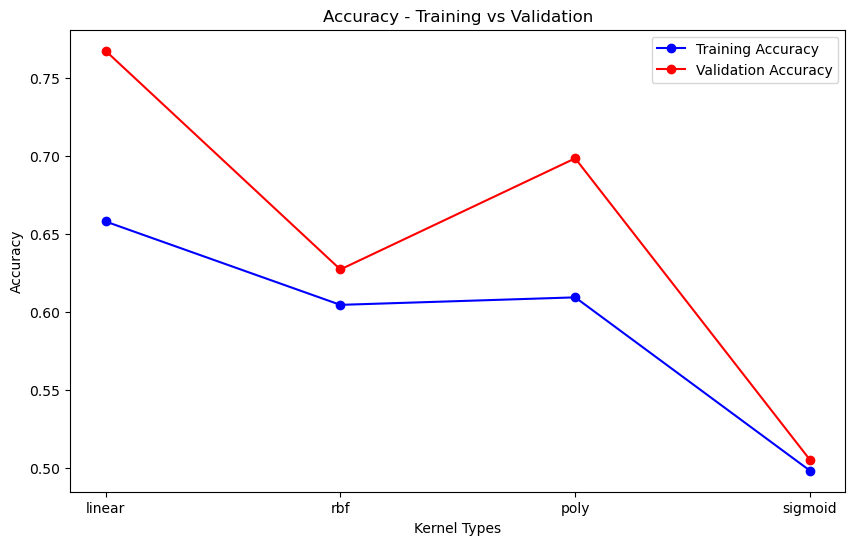

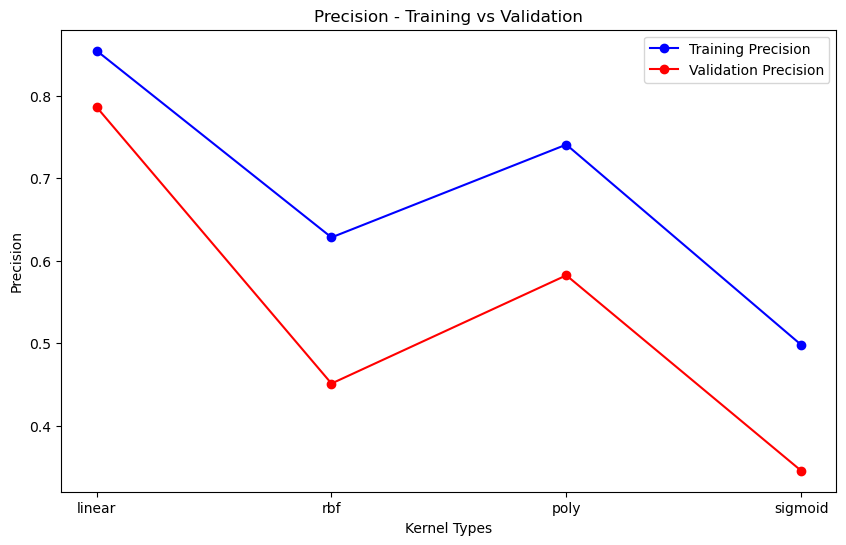

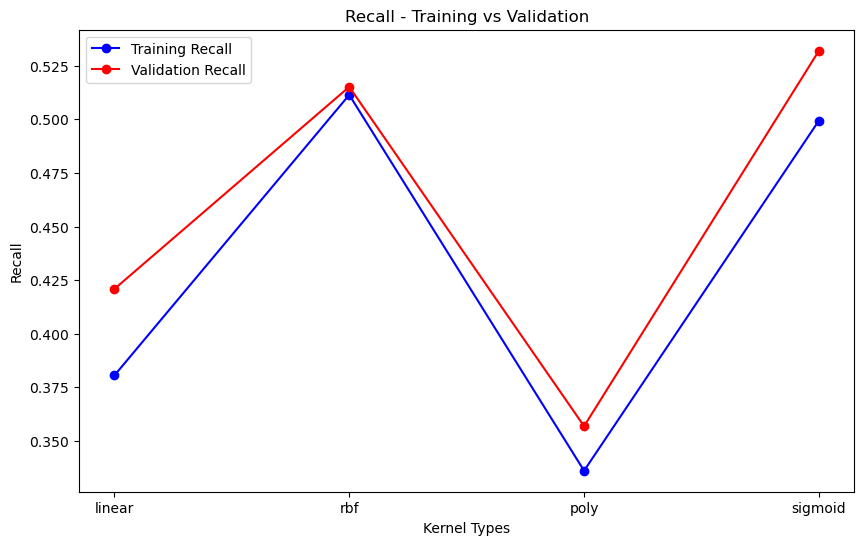

In [5]:
def evaluate_performance(X_train, y_train, X_valid, y_valid, kernel):
    undersampler = RandomUnderSampler(random_state=0)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

    svm = SVC(kernel=kernel, C=1, probability=True)
    svm.fit(X_train_resampled, y_train_resampled)

    y_train_pred = svm.predict(X_train_resampled)
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    train_precision = precision_score(y_train_resampled, y_train_pred)
    train_recall = recall_score(y_train_resampled, y_train_pred)

    y_valid_pred = svm.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    valid_precision = precision_score(y_valid, y_valid_pred)
    valid_recall = recall_score(y_valid, y_valid_pred)

    return train_accuracy, train_precision, train_recall, valid_accuracy, valid_precision, valid_recall

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
accuracy_train = []
accuracy_valid = []
precision_train = []
precision_valid = []
recall_train = []
recall_valid = []

for kernel in kernels:
    train_acc, train_prec, train_rec, valid_acc, valid_prec, valid_rec = evaluate_performance(X_train, y_train, X_val, y_val, kernel)
    accuracy_train.append(train_acc)
    accuracy_valid.append(valid_acc)
    precision_train.append(train_prec)
    precision_valid.append(valid_prec)
    recall_train.append(train_rec)
    recall_valid.append(valid_rec)

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(kernels, accuracy_train, marker='o', label='Training Accuracy', color='blue')
plt.plot(kernels, accuracy_valid, marker='o', label='Validation Accuracy', color='red')
plt.xlabel('Kernel Types')
plt.ylabel('Accuracy')
plt.title('Accuracy - Training vs Validation')
plt.legend()
plt.show()

# Plotting precision
plt.figure(figsize=(10, 6))
plt.plot(kernels, precision_train, marker='o', label='Training Precision', color='blue')
plt.plot(kernels, precision_valid, marker='o', label='Validation Precision', color='red')
plt.xlabel('Kernel Types')
plt.ylabel('Precision')
plt.title('Precision - Training vs Validation')
plt.legend()
plt.show()

# Plotting recall
plt.figure(figsize=(10, 6))
plt.plot(kernels, recall_train, marker='o', label='Training Recall', color='blue')
plt.plot(kernels, recall_valid, marker='o', label='Validation Recall', color='red')
plt.xlabel('Kernel Types')
plt.ylabel('Recall')
plt.title('Recall - Training vs Validation')
plt.legend()
plt.show()

In [7]:
'''
HYPER-PARAMETER TUNING
- creating parameter grid for C and gamma to perform the grid search
 two grids should be explored: one with a linear kernel and C values in 
 [1, 10, 100, 1000], and the second one with an RBF kernel, and the cross-product 
 of C values ranging in [1, 10, 100, 1000] and gamma values in [0.001, 0.0001].
- performs grid search using svm and finds best C and gamma and outputs them 
'''

# Define the parameter grid for the grid search
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Perform grid search with cross-validation
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and their corresponding scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)

# Use the best parameters to train and evaluate the model on the test set
best_svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Score:", best_score)
print("Test Accuracy:", accuracy)

Best Parameters: {'C': 10, 'gamma': 0.01}
Best Score: 0.6710452967937999
Test Accuracy: 0.6836158192090396
